In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
from reldresal import *

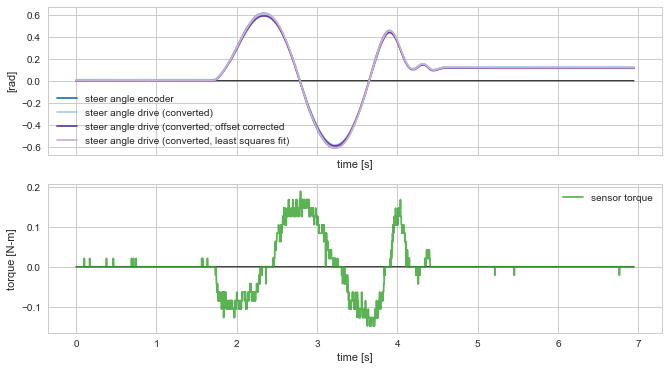

(<matplotlib.figure.Figure at 0x1048aed30>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ea7b7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10eadda90>], dtype=object))

In [3]:
data1 = load_log('no_mass_no_spring.log.gz')
plot_log(data1)

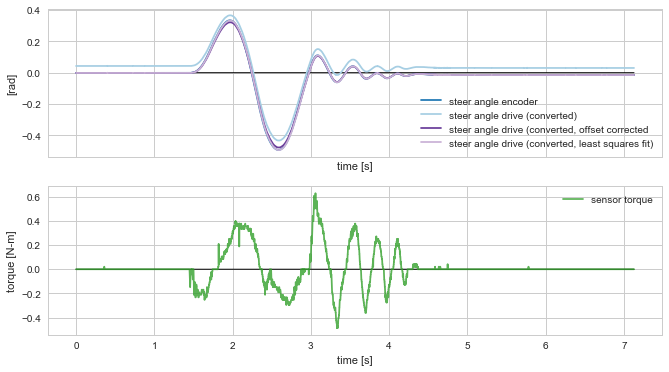

(<matplotlib.figure.Figure at 0x111e34160>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ea198d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111f5bf60>], dtype=object))

In [4]:
data2 = load_log('mass_no_spring.log.gz')
plot_log(data2)

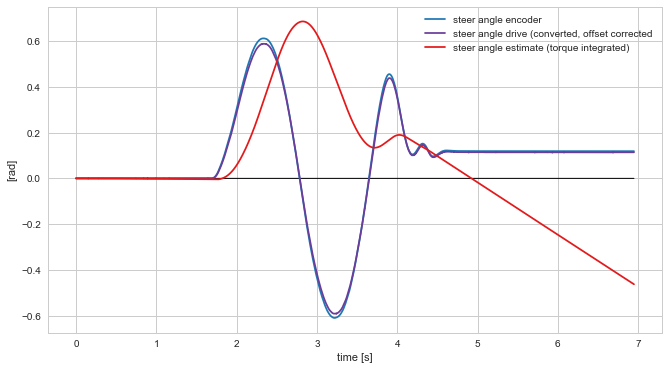

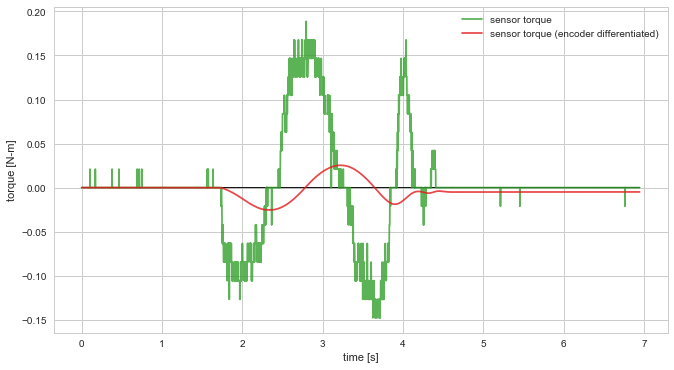

(<matplotlib.figure.Figure at 0x111ee76a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112127c18>)

In [5]:
# For record 1, we use the measured inertia values:
# https://drive.google.com/file/d/0B0TYqj2SzQN5dWlyNDFIb0FKd0k/view
# 
m0 = 0.0413
m1 = 0.0828 - m0
plot_integrated_torque(data1, m1)
plot_differentiated_position(data1, m1)

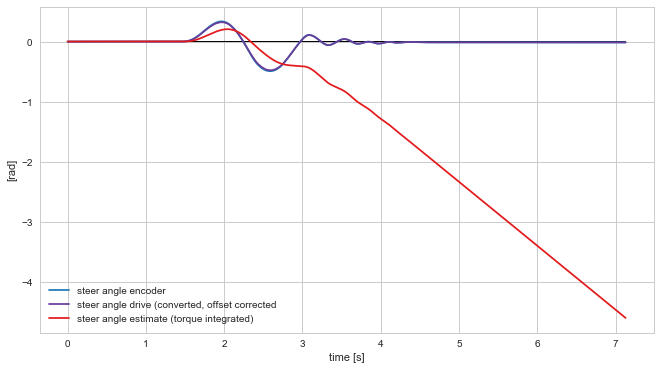

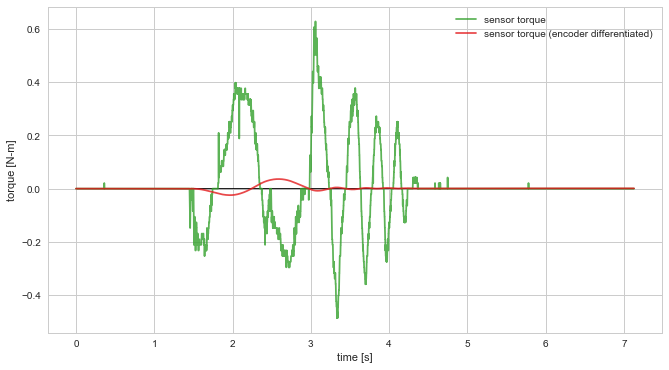

(<matplotlib.figure.Figure at 0x1121f0a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1122eb630>)

In [6]:
# Record has two mass plates of 1 kg located roughly 0.126 m from the shaft center
disc_weight_inertia = 2*(1)*(0.126)**2
plot_integrated_torque(data2, m1 + disc_weight_inertia)
plot_differentiated_position(data2, m1 + disc_weight_inertia)

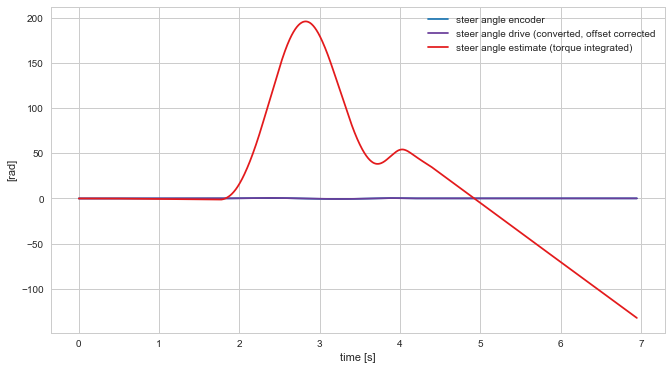

(<matplotlib.figure.Figure at 0x11218f6a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10ea08f28>)

In [7]:
# using kollmorgen motor inertia for m1
m1 = 1.453 / 100 / 100
plot_integrated_torque(data1, m1)